In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end], "-")
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1, np.cos(season_time * 6 * np.pi), 2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1):
  season_time = (time % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(10 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 30
slope = 0.05
noise_level = 2

series = baseline + trend(time, slope) + seasonality(time, 365, amplitude) + noise(time, noise_level, 50)

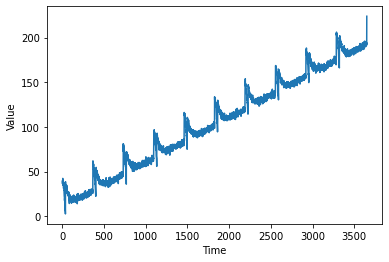

In [5]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [10]:
def windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size +  1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda window: (window[:-1], window[-1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [23]:
forecast = []
for time in range(len(series)-window_size):
  prediction = model.predict(series[time: time + window_size][np.newaxis])
  forecast.append(prediction)
forecast = forecast[split_time - window_size:]

2.1874232


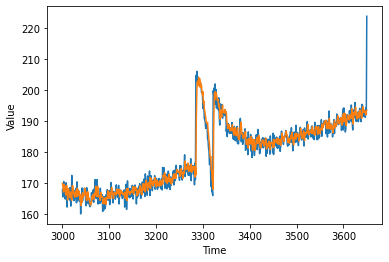

In [25]:
results = np.array(forecast)[:,0,0]
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())